In [1]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Cargar una imagen y procesarla
img = Image.open("cara.jpg")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0)  # Añade un batch dimension

In [3]:
# Modelo: supongamos que usas un modelo preentrenado para el ejemplo
model = models.resnet18(pretrained=True)
model.eval()  # Eval mode

# Función para obtener los mapas de activación
def get_feature_maps(model, x):
    with torch.no_grad():
        for name, layer in model.named_children():
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                yield x

C:\Users\alfon\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


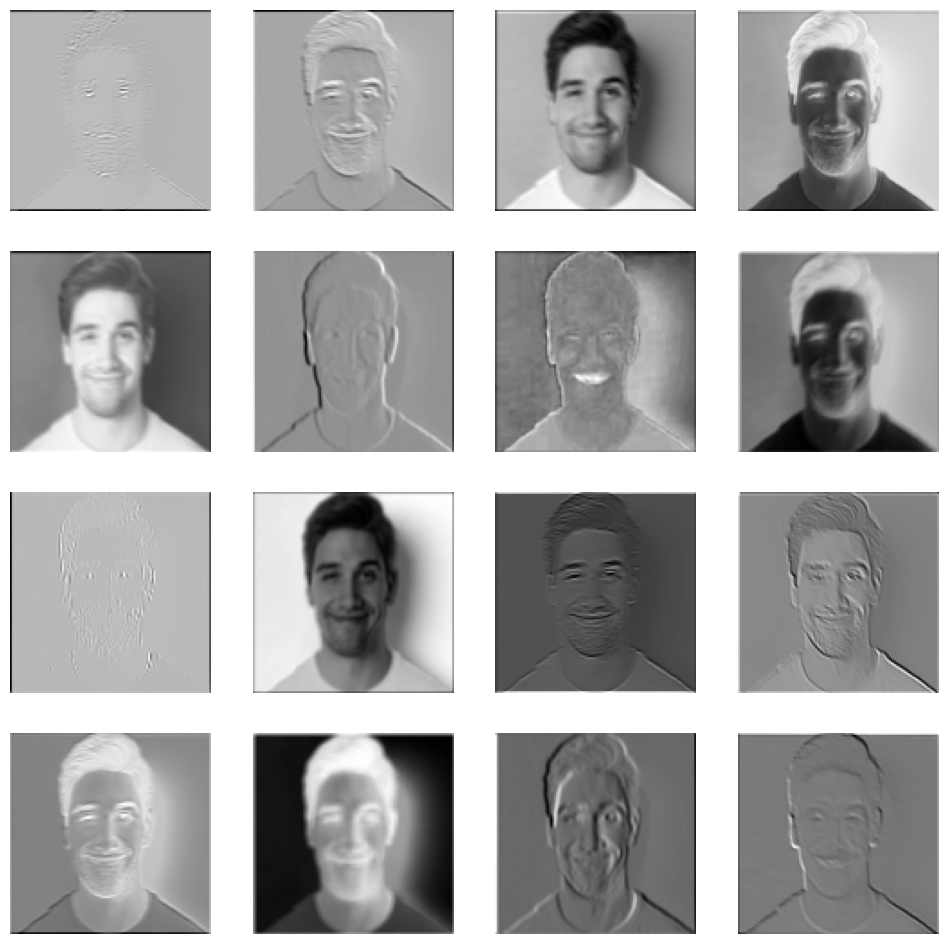

In [4]:
# Visualizar los mapas de activación de la primera capa convolucional
feature_maps = next(get_feature_maps(model, img_tensor))
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

In [5]:
# Define la estructura del modelo

# Model definition
dropout_rate = 0.5
number_raster_layers = 9
number_pixels_layer = 19

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(number_raster_layers, 16, kernel_size=3, stride=1, padding=1)
        self.selu1 = nn.SELU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.selu2 = nn.SELU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.selu3 = nn.SELU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.selu4 = nn.SELU()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.selu5 = nn.SELU()
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.selu6 = nn.SELU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * number_pixels_layer * number_pixels_layer, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.selu1(x)
        x = self.conv2(x)
        x = self.selu2(x)
        x = self.conv3(x)
        x = self.selu3(x)
        x = self.conv4(x)
        x = self.selu4(x)
        x = self.conv5(x)
        x = self.selu5(x)
        x = self.conv6(x)
        x = self.selu6(x)
        x = self.flatten(x)
        # x = self.dropout(x)
        x = self.fc(x)
        return x

model = CNNRegressor()

In [6]:
# Load model
path_model = '../Data/Calibrated_models/global_regressor_V0.pth'
model.load_state_dict(torch.load(path_model))


<All keys matched successfully>

In [7]:
# Cambia el modelo al modo de evaluación (si es necesario)
model.eval()

CNNRegressor(
  (conv1): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu1): SELU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu2): SELU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu3): SELU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu4): SELU()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu5): SELU()
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu6): SELU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=184832, out_features=1, bias=True)
)

In [8]:
# Load tensors
path_tensor_train = '../Data/Calibrated_models/global_regressor_V0_tensor_y_train.pth'
y_train = torch.load(path_tensor_train)

path_tensor_test = '../Data/Calibrated_models/global_regressor_V0_tensor_y_test.pth'
y_test = torch.load(path_tensor_test)

path_tensor_test = '../Data/Calibrated_models/global_regressor_V0_test_tensor.pth'
test_tensor = torch.load(path_tensor_test)

path_tensor_training = '../Data/Calibrated_models/global_regressor_V0_training_tensor.pth'
training_tensor = torch.load(path_tensor_training)

In [9]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)  # Use ReLU para visualizar mejor las activaciones

In [10]:
# Registrar el hook
hook = model.conv1.register_forward_hook(get_activation)

In [16]:
input_tensor = test_tensor[9].unsqueeze(0)
# input_tensor = torch.full((1, 9, 19, 19), 1/9) # 
# Crea un tensor de ceros con la forma deseada
# input_tensor = torch.zeros(1, 9, 19, 19)

# Asigna 1/9 a todos los elementos de la primera capa (capa 0)
#input_tensor[:, 1, :, :] = .5
#input_tensor[:, 0, :, :] = .5

In [17]:
input_tensor.shape

torch.Size([1, 9, 19, 19])

In [18]:
# Convertir el tensor de entrada a float
input_tensor = input_tensor.float()

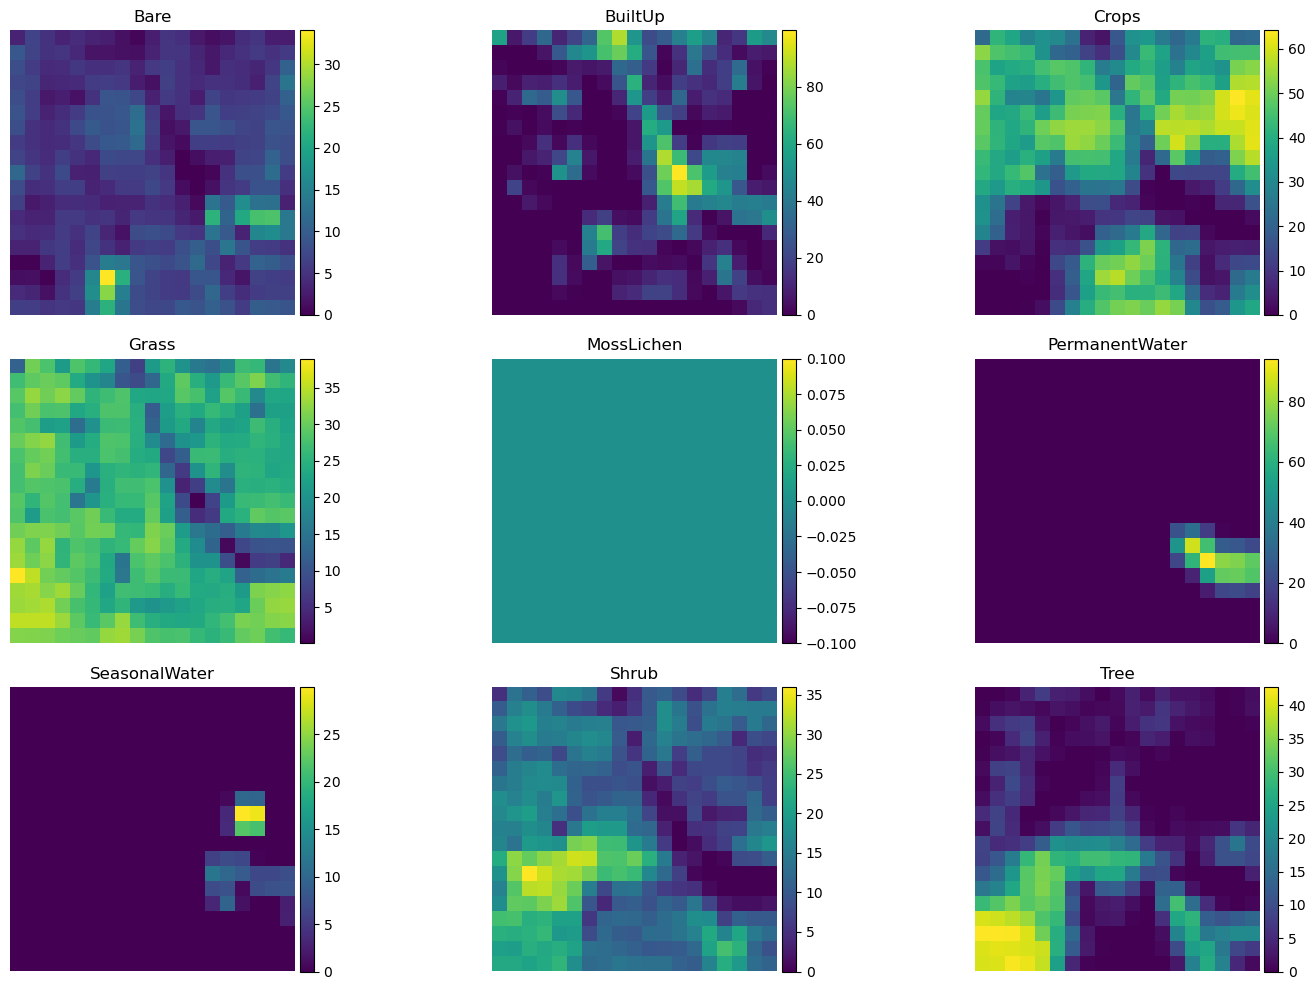

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Asumiendo que input_tensor es de la forma [1, 9, height, width]
# y ya lo has seleccionado correctamente para que tenga esta forma.

# Nombrar las capas según la información proporcionada
layer_names = [
    "Bare", "BuiltUp", "Crops", "Grass", "MossLichen",
    "PermanentWater", "SeasonalWater", "Shrub", "Tree"
]

# Crear una figura para plotear
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Ajusta el tamaño como sea necesario

# Iterar sobre cada capa
for i, ax in enumerate(axes.flatten()):
    # Mostrar la imagen de la capa
    im = ax.imshow(input_tensor[0, i, :, :], cmap='viridis')  # Usa el mapa de colores que prefieras
    ax.set_title(layer_names[i])
    ax.axis('off')  # Desactivar los ejes para una mejor visualización

    # Crear una nueva división para la barra de colores
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Agregar la barra de colores
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb  # Importa específicamente to_rgb

# Supongamos que input_tensor es de la forma [1, 9, height, width]
input_tensor_squeeze = input_tensor.squeeze(0)  # Remover la dimensión del batch

# Definir la paleta de colores según los tipos de cobertura terrestre
color_map = {
    0: 'saddlebrown',   # Bare
    1: 'red',           # BuiltUp
    2: 'yellow',        # Crops
    3: 'lightgreen',    # Grass
    4: 'limegreen',     # MossLichen
    5: 'blue',          # PermanentWater
    6: 'cyan',          # SeasonalWater
    7: 'olive',         # Shrub
    8: 'darkgreen'      # Tree
}

# Determinar la capa dominante para cada píxel
dominant_layer_indices = np.argmax(input_tensor_squeeze, axis=0)

# Crear una imagen RGB vacía
dominant_image = np.zeros((*dominant_layer_indices.shape, 3), dtype=np.uint8)

# Mapear cada índice a su color correspondiente en la imagen RGB
for index, color in color_map.items():
    # Encuentra dónde el índice dominante es igual al índice de la capa actual
    mask = dominant_layer_indices == index
    dominant_image[mask] = np.array(to_rgb(color)) * 255  # Convertir color a RGB y ajustar a escala de 0-255


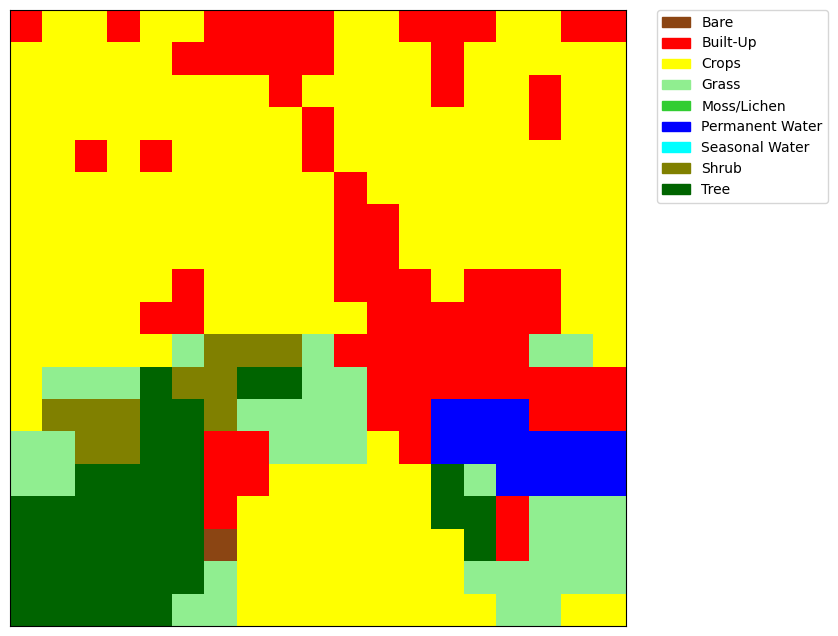

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.patches as mpatches

# Definir la paleta de colores según los tipos de cobertura terrestre
color_map = {
    0: 'saddlebrown',   # Bare
    1: 'red',           # BuiltUp
    2: 'yellow',        # Crops
    3: 'lightgreen',    # Grass
    4: 'limegreen',     # MossLichen
    5: 'blue',          # PermanentWater
    6: 'cyan',          # SeasonalWater
    7: 'olive',         # Shrub
    8: 'darkgreen'      # Tree
}

# Etiquetas para la leyenda basadas en los nombres de las categorías
labels = {
    0: "Bare",
    1: "Built-Up",
    2: "Crops",
    3: "Grass",
    4: "Moss/Lichen",
    5: "Permanent Water",
    6: "Seasonal Water",
    7: "Shrub",
    8: "Tree"
}

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Asumiendo que 'dominant_layer_indices' y 'dominant_image' ya están definidos
ax.imshow(dominant_image)
ax.axis('on')  # Ocultar los ejes

# Crear una lista de parches para la leyenda
patches = [mpatches.Patch(color=to_rgb(color), label=labels[idx]) for idx, color in color_map.items()]

# Añadir la leyenda al gráfico
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Ocultar las etiquetas de los ejes
ax.xaxis.set_ticks([])  # Oculta las etiquetas y marcas del eje x
ax.yaxis.set_ticks([])  # Oculta las etiquetas y marcas del eje y

# Mostrar el gráfico
plt.show()


In [22]:
# Realizar un paso hacia adelante para obtener las activaciones
output = model(input_tensor)

In [23]:
output

tensor([[-4.4576]], grad_fn=<AddmmBackward0>)

In [24]:
# Remover el hook después de usarlo para evitar leaks de memoria
hook.remove()

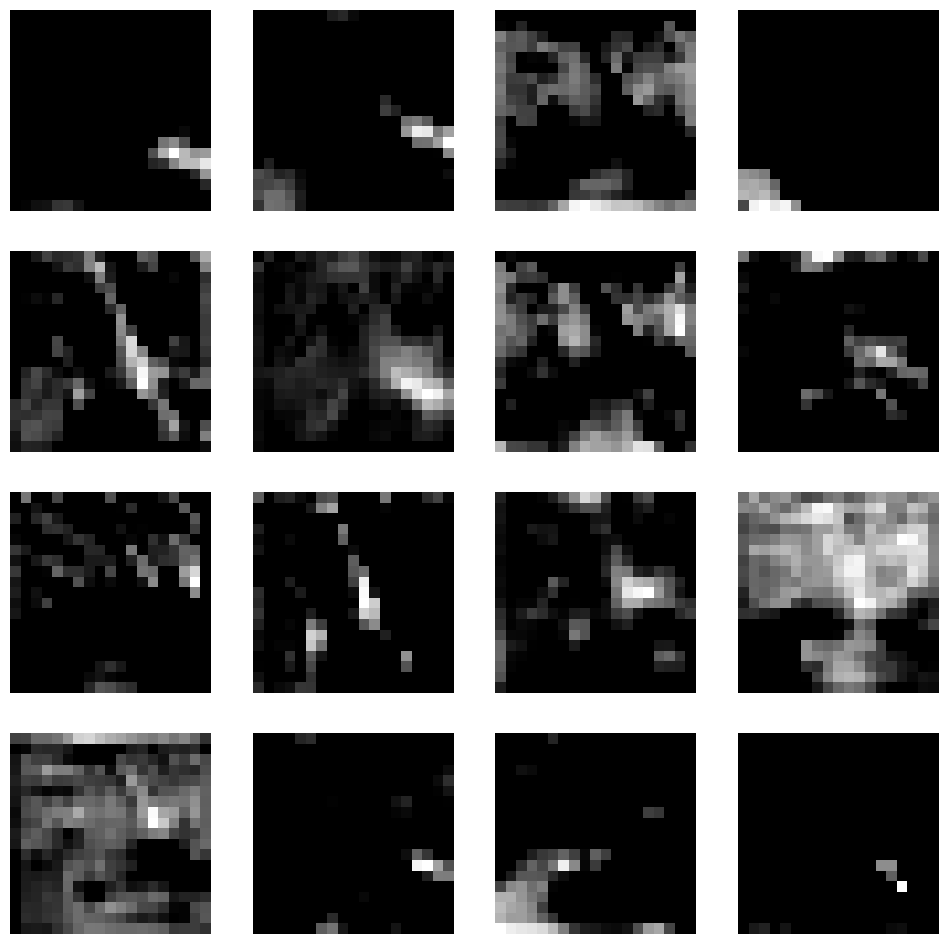

In [25]:
# Verificar que activation está definida
if 'activation' in globals():
    # Visualizar los mapas de activación
    num_plots = activation.shape[1]  # Número de canales en la capa de salida de conv1
    fig, axes = plt.subplots((num_plots + 3) // 4, 4, figsize=(12, (num_plots + 3) // 4 * 3))
    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            ax.imshow(activation[0, i].detach().numpy(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()
else:
    print("No activation data was recorded.")

In [26]:

# Asumiendo que input_tensor es tu tensor de entrada y activations es el tensor de activaciones
# de la forma [batch_size, channels, height, width]
# Por ejemplo, activations podría ser el resultado de model.conv1(input_tensor)

# Convertir los tensores a formato adecuado para cálculos estadísticos
# Aplanamos las dimensiones espaciales para simplificar la correlación
input_flattened = input_tensor.view(input_tensor.size(0), input_tensor.size(1), -1)
activations_flattened = activation.view(activation.size(0), activation.size(1), -1)

# Calcular la correlación para cada par de capas de entrada y activaciones
correlations = torch.zeros((input_tensor.size(1), activation.size(1)))

for i in range(input_tensor.size(1)):  # Iterar sobre cada capa de entrada
    for j in range(activation.size(1)):  # Iterar sobre cada canal de activación
        # Extraemos los datos de una capa y una activación
        input_layer = input_flattened[0, i, :]  # 0 es el índice del batch
        activation_map = activations_flattened[0, j, :]
        
        # Asegurarnos de que no son constantes para evitar divisiones por cero en la correlación
        if input_layer.std() != 0 and activation_map.std() != 0:
            correlation = torch.corrcoef(torch.stack((input_layer, activation_map)))[0, 1]
            correlations[i, j] = correlation

print(correlations)

tensor([[ 2.0163e-01,  1.6819e-01,  2.0718e-01, -1.2131e-01, -2.4686e-01,
          2.4700e-01,  1.9096e-01, -1.8388e-01,  6.1535e-02, -1.3339e-01,
         -3.0359e-01, -2.4234e-01, -3.1051e-02,  4.8309e-01, -1.0167e-01,
          1.3758e-01],
        [-1.1245e-01,  1.6661e-01, -3.6078e-01, -1.5448e-01,  5.6372e-01,
          3.3020e-01, -3.6979e-01,  6.7833e-01, -1.5610e-01,  1.7419e-01,
          6.3089e-01,  3.6693e-01, -5.6996e-03,  2.7562e-02, -2.4144e-01,
         -4.1741e-02],
        [-2.7346e-01, -4.0648e-01,  6.3203e-01, -3.1734e-01, -4.8082e-01,
         -4.8476e-01,  6.1207e-01, -3.0777e-01,  4.1213e-01, -2.1359e-01,
         -3.0671e-01,  5.7297e-01,  4.1040e-01, -1.5605e-01, -4.5213e-01,
         -1.5102e-01],
        [-3.5904e-01, -1.2152e-01,  2.1078e-01,  2.6147e-01, -3.5563e-01,
         -5.8981e-01,  1.9068e-01, -4.6147e-01,  5.9265e-02, -6.5571e-02,
         -3.6061e-01, -3.2390e-01, -1.1655e-02, -2.4645e-01,  3.6001e-01,
         -2.0343e-01],
        [ 0.0000e+00

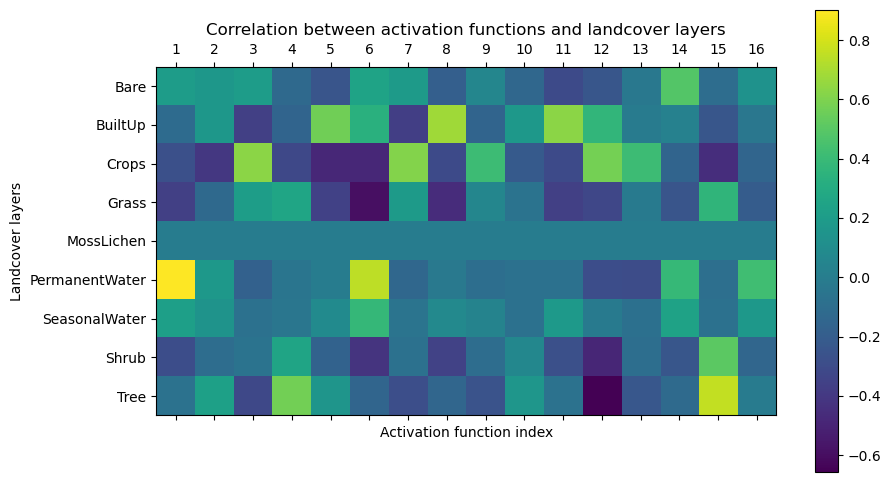

In [27]:
# Convertir el tensor a un array de NumPy
correlations_array = correlations.detach().numpy()
# Lista de nombres de las capas de cobertura
layer_names = ["Bare", "BuiltUp", "Crops", "Grass", "MossLichen",
               "PermanentWater", "SeasonalWater", "Shrub", "Tree"]

# Usar matshow para visualizar el tensor
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(correlations_array, cmap='viridis')
fig.colorbar(cax)

# Establecer los nombres de las capas como etiquetas de las filas
ax.set_yticks(range(len(layer_names)))
ax.set_yticklabels(layer_names)

# Puedes también ajustar las etiquetas de las columnas si es necesario
ax.set_xticks(range(correlations.size(1)))
ax.set_xticklabels(range(1, correlations.size(1) + 1))

plt.title("Correlation between activation functions and landcover layers")
plt.xlabel("Activation function index")
plt.ylabel("Landcover layers")
plt.show()

In [36]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.layer = layer
        self.gradient = None
        self.activation = None

        self.hook_handles = []
        self.hook_handles.append(layer.register_forward_hook(self.save_activation))
        self.hook_handles.append(layer.register_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activation = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0].detach()

    def __call__(self, x, index=None):
        output = self.model(x)
        if index is None:
            index = torch.argmax(output)

        self.model.zero_grad()
        output.backward(torch.ones_like(output), retain_graph=True)  # Simplificado

        pooled_gradients = torch.mean(self.gradient, dim=[0, 2, 3])
        for i in range(pooled_gradients.size(0)):
            self.activation[:, i, :, :] *= pooled_gradients[i]
        
        heatmap = torch.mean(self.activation, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap

    def release(self):
        for handle in self.hook_handles:
            handle.remove()


In [37]:
# Uso de GradCAM en el modelo con la capa conv6
grad_cam = GradCAM(model, model.conv6)

In [38]:
# Obtención del mapa de calor
heatmap = grad_cam(input_tensor)
grad_cam.release()

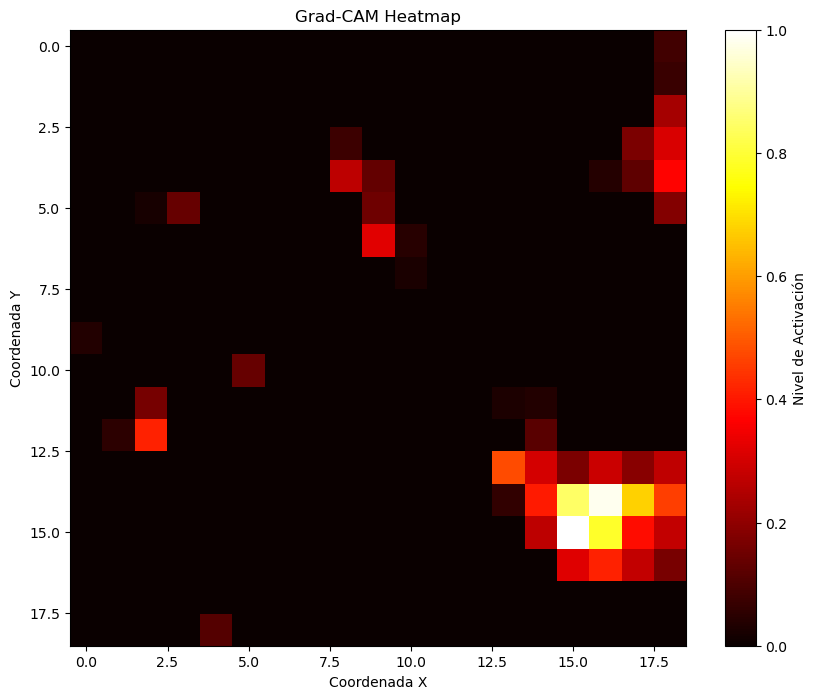

In [39]:
import matplotlib.pyplot as plt

# Asumiendo que `heatmap` es el mapa de calor que has calculado con Grad-CAM
heatmap_np = heatmap.cpu().numpy()  # Convertir el tensor a un array de NumPy para visualización
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura si es necesario
plt.imshow(heatmap_np, cmap='hot')  # 'viridis' es una buena elección de mapa de colores, pero puedes elegir otro

# Añadir la barra de colores
cbar = plt.colorbar()
cbar.set_label('Nivel de Activación')

# Añadir títulos y etiquetas si es necesario
plt.title('Grad-CAM Heatmap')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')

plt.show()

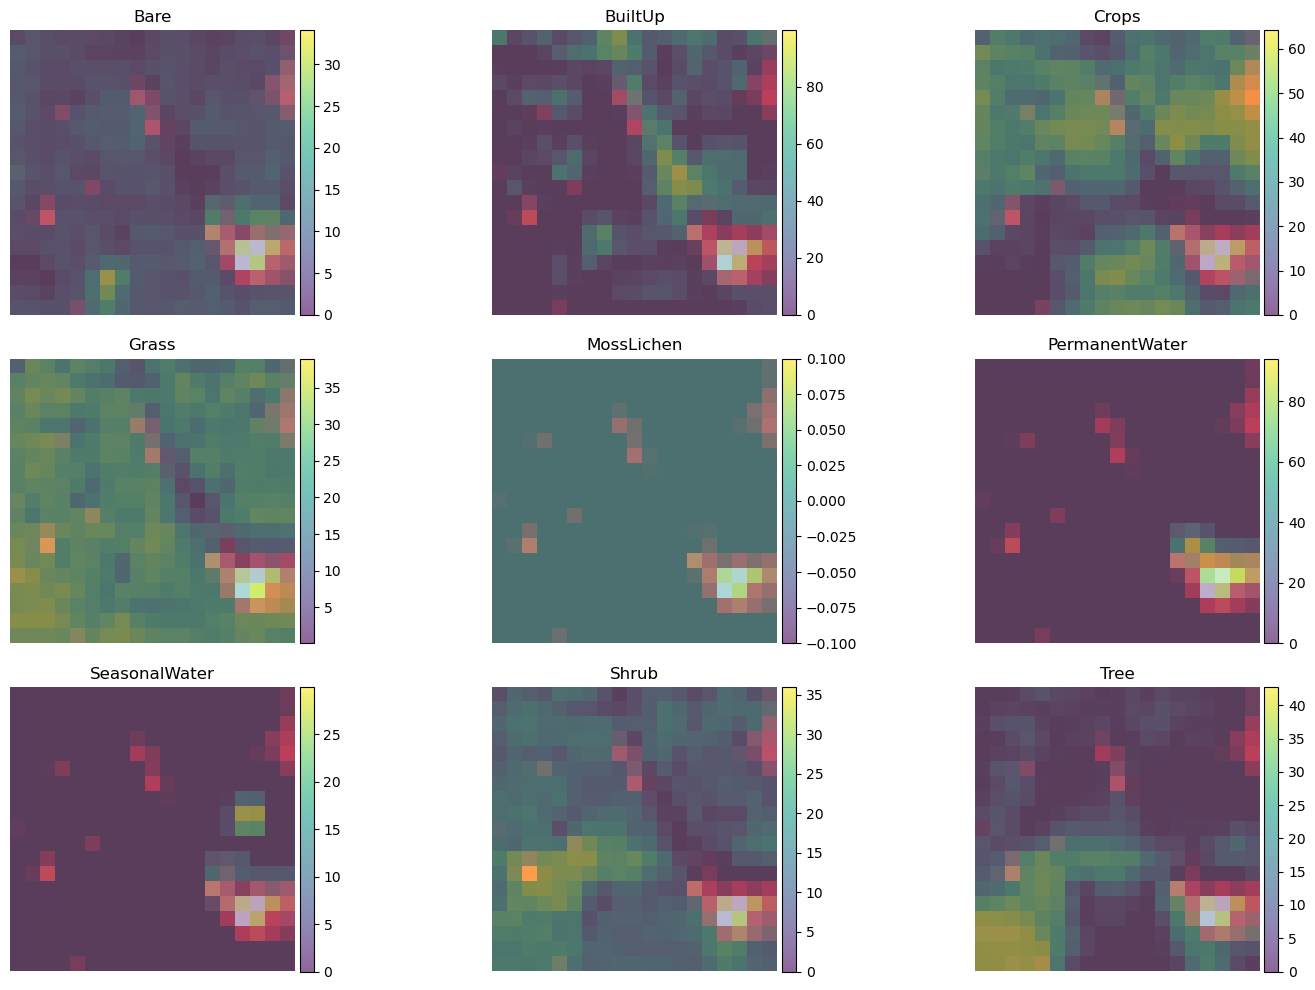

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Asumiendo que input_tensor es de la forma [1, 9, height, width]
# Asumiendo que heatmap es un tensor de la forma [height, width]
# Asegúrate de que el heatmap es del mismo tamaño que las capas del input_tensor

# Nombrar las capas según la información proporcionada
layer_names = [
    "Bare", "BuiltUp", "Crops", "Grass", "MossLichen",
    "PermanentWater", "SeasonalWater", "Shrub", "Tree"
]

# Crear una figura para plotear
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Ajusta el tamaño como sea necesario

# Iterar sobre cada capa
for i, ax in enumerate(axes.flatten()):
    # Mostrar la imagen de la capa
    im = ax.imshow(input_tensor[0, i, :, :], cmap='viridis', alpha=0.6)  # Imagen de fondo con cierta transparencia
    
    # Superponer el heatmap de Grad-CAM
    # Asegúrate de que el heatmap esté normalizado o ajusta su escala adecuadamente
    ax.imshow(heatmap, cmap='hot', alpha=0.4)  # Superposición con transparencia

    ax.set_title(layer_names[i])
    ax.axis('off')  # Desactivar los ejes para una mejor visualización

    # Crear una nueva división para la barra de colores de la capa
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Agregar la barra de colores para la capa
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [33]:
import numpy as np

# Asumiendo que input_tensor es de la forma [1, 9, height, width]
# y heatmap es de la forma [height, width]
input_tensor_squeeze = input_tensor.squeeze(0)  # Elimina la dimensión batch si está presente

# Correlaciones entre el heatmap y cada capa
correlations = []

for i in range(input_tensor_squeeze.shape[0]):  # Iterar sobre el número de capas
    layer_data = input_tensor_squeeze[i, :, :].numpy()  # Convertir la capa a NumPy array
    heatmap_data = heatmap.numpy()  # Asegúrate de que el heatmap está en forma NumPy

    # Aplanar los datos para correlación
    layer_flat = layer_data.flatten()
    heatmap_flat = heatmap_data.flatten()

    # Calcular la correlación de Pearson
    correlation = np.corrcoef(layer_flat, heatmap_flat)[0, 1]
    correlations.append(correlation)

    # Imprimir la correlación para cada capa
    print(f"Correlación entre el heatmap y la capa {i} ({layer_names[i]}): {correlation:.3f}")

Correlación entre el heatmap y la capa 0 (Bare): 0.094
Correlación entre el heatmap y la capa 1 (BuiltUp): -0.062
Correlación entre el heatmap y la capa 2 (Crops): -0.185
Correlación entre el heatmap y la capa 3 (Grass): -0.145
Correlación entre el heatmap y la capa 4 (MossLichen): nan
Correlación entre el heatmap y la capa 5 (PermanentWater): 0.508
Correlación entre el heatmap y la capa 6 (SeasonalWater): 0.074
Correlación entre el heatmap y la capa 7 (Shrub): -0.177
Correlación entre el heatmap y la capa 8 (Tree): -0.009


C:\Users\alfon\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\alfon\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


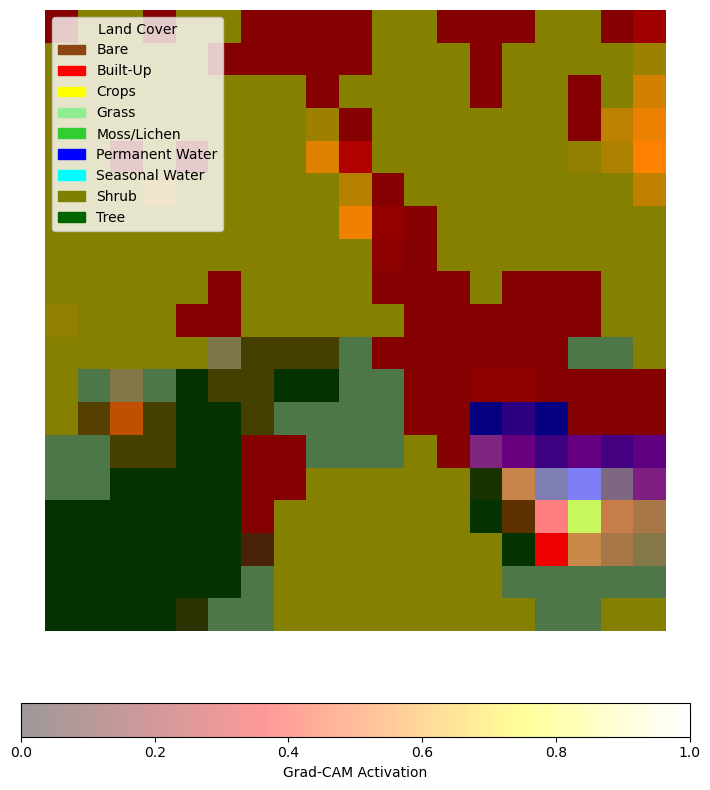

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgb, Normalize
from matplotlib.cm import ScalarMappable

# Configurar el tamaño de la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Mostrar la imagen de cobertura de suelo dominante
ax.imshow(dominant_image)
ax.axis('off')  # Ocultar los ejes

# Superponer el heatmap con una transparencia del 40%
ax.imshow(heatmap, cmap='hot', alpha=.5)

# Crear una lista de parches para la leyenda de la cobertura de suelo
patches = [mpatches.Patch(color=to_rgb(color), label=labels[idx]) for idx, color in color_map.items()]
# Añadir la leyenda para la cobertura de suelo, ubicándola dentro del gráfico
legend1 = ax.legend(handles=patches, loc='upper left', title="Land Cover")

# Configurar la barra de color horizontal en la parte inferior
norm = Normalize(vmin=heatmap.min(), vmax=heatmap.max())
sm = ScalarMappable(norm=norm, cmap='hot')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1, alpha=0.4)
cbar.set_label('Grad-CAM Activation')

# Ajustar el layout para dar espacio a todos los componentes
plt.tight_layout()

# Mostrar la figura
plt.show()


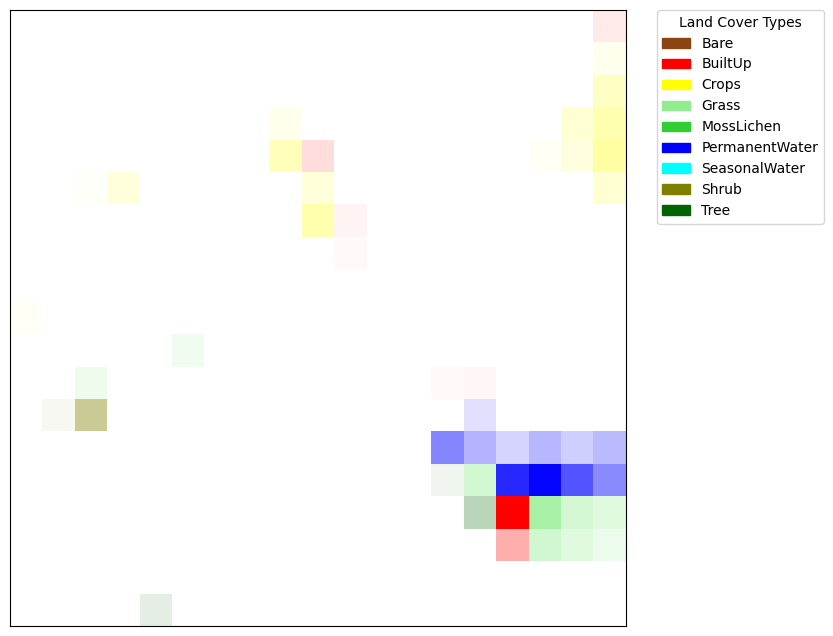

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_rgb
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Asumiendo que 'dominant_image' y 'heatmap' están definidos
# Asegurarse de que el heatmap está normalizado
normalized_heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Crear una imagen RGBA para `dominant_image` donde el canal alfa se ajusta según el heatmap
dominant_rgba_image = np.zeros((*dominant_image.shape[:2], 4), dtype=np.float32)  # Crear imagen RGBA

for i in range(3):  # Copiar los canales RGB
    dominant_rgba_image[..., i] = dominant_image[..., i] / 255.0  # Normalizar y copiar
dominant_rgba_image[..., 3] = normalized_heatmap  # Ajustar el canal alfa usando el heatmap

# Configurar la visualización
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(dominant_rgba_image)  # Mostrar la imagen RGBA
ax.axis('on')  # Mostrar los ejes


# Definir la paleta de colores y las etiquetas para la leyenda de `dominant_image`
color_map = {
    "Bare": 'saddlebrown',
    "BuiltUp": 'red',
    "Crops": 'yellow',
    "Grass": 'lightgreen',
    "MossLichen": 'limegreen',
    "PermanentWater": 'blue',
    "SeasonalWater": 'cyan',
    "Shrub": 'olive',
    "Tree": 'darkgreen'
}
patches = [mpatches.Patch(color=to_rgb(color), label=label) for label, color in color_map.items()]

# Ocultar las etiquetas de los ejes
ax.xaxis.set_ticks([])  # Oculta las etiquetas y marcas del eje x
ax.yaxis.set_ticks([])  # Oculta las etiquetas y marcas del eje y

# Añadir la leyenda para la cobertura de suelo
legend = ax.legend(handles=patches, loc='upper left', title="Land Cover Types", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

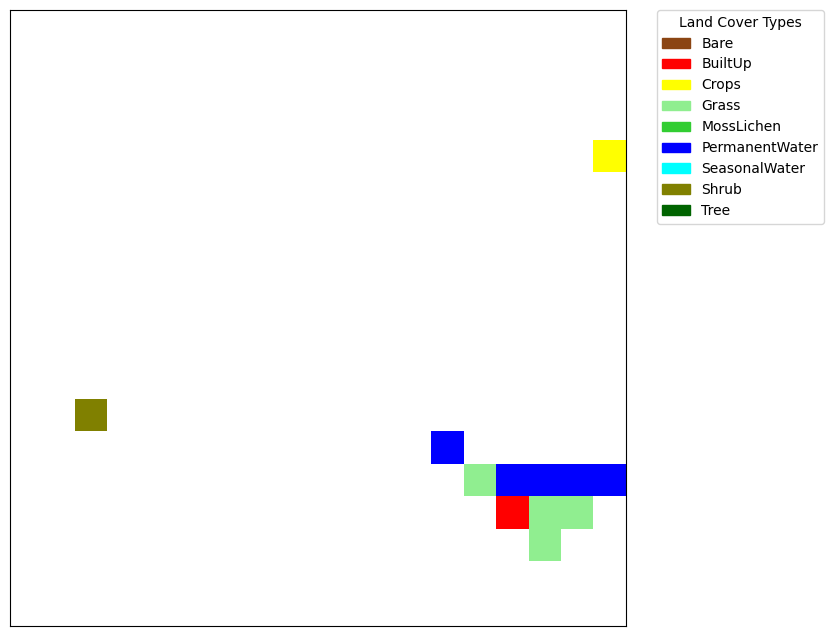

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_rgb
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

# Asumiendo que 'dominant_image' y 'heatmap' están definidos
# Asegurarse de que el heatmap está normalizado
normalized_heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Crear una imagen RGBA para `dominant_image` donde el canal alfa se ajusta según el heatmap
dominant_rgba_image = np.zeros((*dominant_image.shape[:2], 4), dtype=np.float32)  # Crear imagen RGBA

for i in range(3):  # Copiar los canales RGB
    dominant_rgba_image[..., i] = dominant_image[..., i] / 255.0  # Normalizar y copiar

# Ajustar el canal alfa usando el heatmap con el umbral
threshold = 0.33
alpha_channel = np.where(normalized_heatmap > threshold, 1.0, 0) #normalized_heatmap, 0)
dominant_rgba_image[..., 3] = alpha_channel  # Aplicar el canal alfa modificado

# Configurar la visualización
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(dominant_rgba_image)  # Mostrar la imagen RGBA
ax.axis('on')  # Mostrar los ejes

# Definir la paleta de colores y las etiquetas para la leyenda de `dominant_image`
color_map = {
    "Bare": 'saddlebrown',
    "BuiltUp": 'red',
    "Crops": 'yellow',
    "Grass": 'lightgreen',
    "MossLichen": 'limegreen',
    "PermanentWater": 'blue',
    "SeasonalWater": 'cyan',
    "Shrub": 'olive',
    "Tree": 'darkgreen'
}
patches = [mpatches.Patch(color=to_rgb(color), label=label) for label, color in color_map.items()]

# Ocultar las etiquetas de los ejes
ax.xaxis.set_ticks([])  # Oculta las etiquetas y marcas del eje x
ax.yaxis.set_ticks([])  # Oculta las etiquetas y marcas del eje y

# Añadir la leyenda para la cobertura de suelo
legend = ax.legend(handles=patches, loc='upper left', title="Land Cover Types", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()


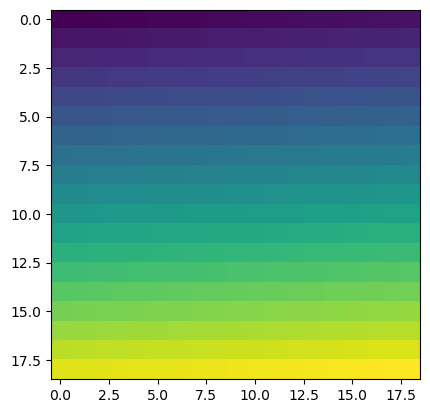

In [74]:
# 1. Segmentación usando scikit-image
from skimage.segmentation import slic
from skimage.util import img_as_float

# Convertir la imagen a un formato adecuado para procesamiento
dominant_float_image = img_as_float(dominant_rgba_image)

# Aplicar SLIC para segmentar la imagen en superpíxeles
# Usar `channel_axis=-1` para especificar que los canales están en el último eje
segments = slic(dominant_float_image, n_segments=500, compactness=10, sigma=1, channel_axis=-1)

# Mostrar la segmentación
plt.imshow(segments)
plt.show()

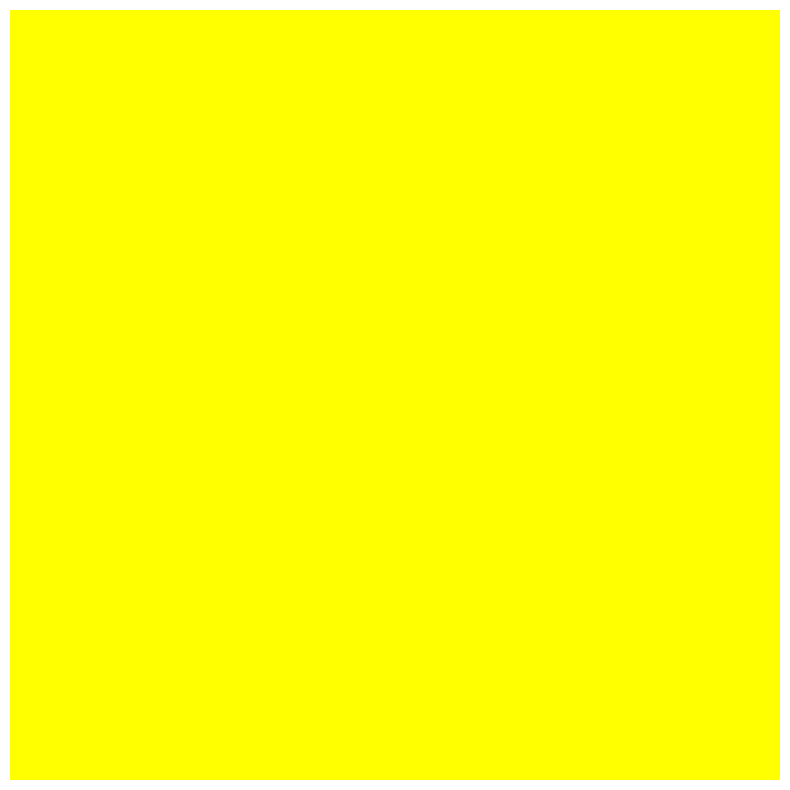

In [79]:
segments

In [76]:
# 2. Extracción de estadísticas
import numpy as np

# Cálculo de estadísticas por cluster, por ejemplo, el promedio de valores en cada canal
for segment_label in np.unique(segments):
    mask = segments == segment_label
    mean_color = dominant_float_image[mask].mean(axis=0)
    print(f"Cluster {segment_label}: Mean color {mean_color}")

Cluster 1: Mean color [1. 0. 0. 0.]
Cluster 2: Mean color [1. 1. 0. 0.]
Cluster 3: Mean color [1. 1. 0. 0.]
Cluster 4: Mean color [1. 0. 0. 0.]
Cluster 5: Mean color [1. 1. 0. 0.]
Cluster 6: Mean color [1. 1. 0. 0.]
Cluster 7: Mean color [1. 0. 0. 0.]
Cluster 8: Mean color [1. 0. 0. 0.]
Cluster 9: Mean color [1. 0. 0. 0.]
Cluster 10: Mean color [1. 0. 0. 0.]
Cluster 11: Mean color [1. 1. 0. 0.]
Cluster 12: Mean color [1. 1. 0. 0.]
Cluster 13: Mean color [1. 0. 0. 0.]
Cluster 14: Mean color [1. 0. 0. 0.]
Cluster 15: Mean color [1. 0. 0. 0.]
Cluster 16: Mean color [1. 1. 0. 0.]
Cluster 17: Mean color [1. 1. 0. 0.]
Cluster 18: Mean color [1. 0. 0. 0.]
Cluster 19: Mean color [1. 0. 0. 0.]
Cluster 20: Mean color [1. 1. 0. 0.]
Cluster 21: Mean color [1. 1. 0. 0.]
Cluster 22: Mean color [1. 1. 0. 0.]
Cluster 23: Mean color [1. 1. 0. 0.]
Cluster 24: Mean color [1. 1. 0. 0.]
Cluster 25: Mean color [1. 0. 0. 0.]
Cluster 26: Mean color [1. 0. 0. 0.]
Cluster 27: Mean color [1. 0. 0. 0.]
Cluster 28

In [77]:
# 3. Análisis de los alrededores de cada cluster
from skimage.morphology import dilation, square

# Dilatar los segmentos para incluir un borde
dilated_segments = dilation(segments, square(3))

# Calcular estadísticas para el borde
for segment_label in np.unique(segments):
    mask = dilated_segments == segment_label
    border_mask = mask & ~ (segments == segment_label)
    mean_border_color = dominant_float_image[border_mask].mean(axis=0)
    print(f"Cluster {segment_label}: Mean border color {mean_border_color}")

Cluster 1: Mean border color [nan nan nan nan]
Cluster 2: Mean border color [nan nan nan nan]
Cluster 3: Mean border color [nan nan nan nan]
Cluster 4: Mean border color [nan nan nan nan]
Cluster 5: Mean border color [nan nan nan nan]
Cluster 6: Mean border color [nan nan nan nan]
Cluster 7: Mean border color [nan nan nan nan]
Cluster 8: Mean border color [nan nan nan nan]
Cluster 9: Mean border color [nan nan nan nan]
Cluster 10: Mean border color [nan nan nan nan]
Cluster 11: Mean border color [nan nan nan nan]
Cluster 12: Mean border color [nan nan nan nan]
Cluster 13: Mean border color [nan nan nan nan]
Cluster 14: Mean border color [nan nan nan nan]
Cluster 15: Mean border color [nan nan nan nan]
Cluster 16: Mean border color [nan nan nan nan]
Cluster 17: Mean border color [nan nan nan nan]
Cluster 18: Mean border color [nan nan nan nan]
Cluster 19: Mean border color [nan nan nan nan]
Cluster 20: Mean border color [nan nan nan nan]
Cluster 21: Mean border color [1. 0. 0. 0.]
Clust

C:\Users\alfon\AppData\Local\Temp\ipykernel_14368\325568305.py:11: RuntimeWarning: Mean of empty slice.
  mean_border_color = dominant_float_image[border_mask].mean(axis=0)
C:\Users\alfon\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [72]:
from PIL import Image

# Asumimos que 'dominant_rgba_image' está en rango [0, 1]. Convertirlo a [0, 255] y tipo de datos uint8.
dominant_rgba_image_uint8 = (dominant_rgba_image * 255).astype(np.uint8)

# Crear un objeto de imagen de Pillow
img = Image.fromarray(dominant_rgba_image_uint8, 'RGBA')

# Guardar la imagen
img.save('dominant_rgba_image.png')

In [50]:
import cv2

# Cargar la imagen
image = cv2.imread('dominant_rgba_image.png', cv2.IMREAD_UNCHANGED)  # Usa UNCHANGED para asegurar que el canal alfa se carga también

# Convertir de BGR a RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)  # Asegúrate de convertir BGRA a RGBA si el canal alfa está presente

In [56]:
import numpy as np
from sklearn.cluster import KMeans

# Preparar los datos para el clustering: cambiar la forma de la imagen para que sea un array de forma (num_píxeles, num_canales)
pixels = image_rgb.reshape((-1, 4))  # Asegúrate de incluir el canal alfa

# Aplicar K-means
num_clusters = 10  # Define el número de clusters deseado
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pixels)
labels = kmeans.labels_

# Crear una imagen segmentada basada en los centroides encontrados
segmented_image = kmeans.cluster_centers_[labels].reshape(image_rgb.shape)
segmented_image = np.clip(segmented_image, 0, 255).astype(np.uint8)

# Mostrar la imagen segmentada
cv2.imshow('Segmented Image', cv2.cvtColor(segmented_image, cv2.COLOR_RGBA2BGRA))  # Convertir de RGBA a BGRA para mostrar
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [57]:
import cv2
import numpy as np

# Redimensionar la imagen
width, height = 600, 600  # Establece el nuevo tamaño
resized_image = cv2.resize(cv2.cvtColor(segmented_image, cv2.COLOR_RGBA2BGRA), (width, height))

# Mostrar la imagen redimensionada
cv2.imshow('Segmented Image', resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [58]:
# Guardar la imagen segmentada
cv2.imwrite('segmented_dominant_rgba_image.png', cv2.cvtColor(segmented_image, cv2.COLOR_RGBA2BGRA))

True

In [66]:
# 1. Análisis de Componentes Conectados

import cv2
import numpy as np

# Si tu imagen segmentada es RGBA, primero elimina el canal alfa si es necesario:
if segmented_image.shape[2] == 4:
    segmented_image = segmented_image[:, :, :3]

# Convertir imagen RGB a escala de grises
gray_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)

# Alternativamente, podrías usar una simple media de los canales si eso es suficiente para tu caso:
# gray_image = segmented_image.mean(axis=2).astype(np.uint8)

# Ahora aplicar connectedComponents
ret, labels = cv2.connectedComponents(gray_image)

# Calcular la cantidad de componentes únicos
num_labels = labels.max()
print("Número de componentes conectados:", num_labels)

# Crear una imagen de color para visualizar los componentes
label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0  # Poner el fondo en negro

# Mostrar la imagen
cv2.imshow('Componentes Conectados', labeled_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Número de componentes conectados: 1


In [67]:
# 2. Cálculo de Áreas y Perímetros

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que ya tienes 'segmented_image' definida y lista para usar
# Asegúrate de que esta imagen es en escala de grises o conviértela si es necesario
if segmented_image.shape[-1] == 4:  # Si es RGBA
    gray_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGBA2GRAY)
elif segmented_image.shape[-1] == 3:  # Si es RGB
    gray_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
else:
    gray_image = segmented_image  # Asumiendo que ya está en escala de grises

# Aplicar Connected Components para obtener las etiquetas
ret, labels = cv2.connectedComponents(gray_image)
num_labels = labels.max()
print("Número de componentes conectados:", num_labels)

# Calcular y visualizar áreas y perímetros
for i in range(1, num_labels + 1):  # Comenzando en 1 para ignorar el fondo
    mask = np.array(labels == i, dtype=np.uint8)
    area = cv2.countNonZero(mask)
    # Encontrar contornos para el cálculo del perímetro
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = cv2.arcLength(contours[0], True)  # Asumiendo que cada componente tiene un solo contorno

    print(f"Área del componente {i}: {area} píxeles")
    print(f"Perímetro del componente {i}: {perimeter} píxeles")


Número de componentes conectados: 1
Área del componente 1: 361 píxeles
Perímetro del componente 1: 72.0 píxeles


In [68]:
# 3. Estadísticas de Color por Cluster

print("Dimensiones de image_rgb:", image_rgb.shape)
print("Dimensiones de labels:", labels.shape)

Dimensiones de image_rgb: (19, 19, 4)
Dimensiones de labels: (19, 19)
